In [899]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, f1_score, accuracy_score, make_scorer
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings

warnings.simplefilter("ignore")

%config IPCompleter.greedy=True

## Loading the Dataset

In [900]:
path = kagglehub.dataset_download("luvathoms/portugal-real-estate-2024")
print("Path to access the dataset:", path)

Path to access the dataset: /Users/andriyvovchak/.cache/kagglehub/datasets/luvathoms/portugal-real-estate-2024/versions/19


## Exploring the Dataset

In [901]:
dataset = pd.read_csv("/Users/andriyvovchak/.cache/kagglehub/datasets/luvathoms/portugal-real-estate-2024/versions/19/portugal_listinigs.csv")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
0,780000.00,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.00,552450.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.00,NaN,NaN,0.00
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,81.00,NaN,NaN,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,108.00,NaN,NaN,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,0.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,2.00


### Dataset Features and their meaning

- **Price**: The asking price of the property in Euros.
- **District, City, Town**: The geographical location of the property.
- **Type**: The type of property (e.g., Apartment, House, Garage, Land).
- **EnergyCertificate**: The energy efficiency rating of the property, according to Portuguese energy certification standards.
- **Area Measurements**: Several columns related to the size and area of the property, including:
    - **GrossPrivateArea**: The private gross area of the property.
    - **UsableArea**: The area that can be used for living.
    - **LivingArea**: The actual livable space inside the property.
    - **LotSize**: The size of the land associated with the property.
    - **BuiltArea**: The total constructed area of the property.
- **Rooms, Bedrooms, Bathrooms, WCs**: Detailed breakdowns of the number of rooms, bedrooms, bathrooms, and water closets in the property.
- **Floor**: The floor on which the property is located.
- **Parking, Garage**: Information on parking availability and the presence of a garage.
- **Additional Features**: Whether the property includes amenities like elevators or electric car charging stations.
- **ConstructionYear**: The year the property was built.
- **PublishDate**: The date when the listing was published.

In [902]:
dataset.shape

(135536, 25)

In [903]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135536 entries, 0 to 135535
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  135236 non-null  float64
 1   District               135536 non-null  object 
 2   City                   135536 non-null  object 
 3   Town                   135534 non-null  object 
 4   Type                   135520 non-null  object 
 5   EnergyCertificate      135522 non-null  object 
 6   GrossArea              27638 non-null   float64
 7   TotalArea              127153 non-null  float64
 8   Parking                135342 non-null  float64
 9   HasParking             68215 non-null   object 
 10  Floor                  27929 non-null   object 
 11  ConstructionYear       88021 non-null   float64
 12  EnergyEfficiencyLevel  67289 non-null   object 
 13  PublishDate            29239 non-null   object 
 14  Garage                 67289 non-nul

Differentiating categorical and numerical features. 

In [904]:
x_numeric = ["Price", "GrossArea", "Parking", "ConstructionYear", 
             "TotalRooms", "NumberOfBedrooms", "NumberOfWC", 
             "LivingArea", "LotSize", "BuiltArea", "NumberOfBathrooms"]

x_categorical = ["ConservationStatus", "ElectricCarsCharging", "Elevator",
                 "Garage", "PublishDate", "EnergyEfficiencyLevel",
                 "Floor", "HasParking", "EnergyCertificate",
                 "Type", "Town", "City"]

In [905]:
dataset[x_numeric].describe()

,Price,GrossArea,Parking,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
count,135236.00,27638.00,135342.00,88021.00,73244.00,47041.00,57256.00,104952.00,39583.00,26617.00,128700.00
mean,368137.45,2789.73,0.55,1989.30,3.23,2.67,0.43,1403.04,56369.39,3086.62,1.54
std,3804044.27,115366.98,0.84,26.68,10.52,1.79,1.02,34745.97,5208473.72,118513.70,1.76
min,1.00,-7.00,0.00,1900.00,0.00,0.00,-15.00,0.00,0.00,-1.00,-13.00
25%,84000.00,100.00,0.00,1973.00,2.00,2.00,0.00,80.00,258.00,104.57,0.00
50%,210000.00,164.00,0.00,1994.00,3.00,3.00,0.00,118.00,679.00,168.00,1.00
75%,395000.00,294.00,1.00,2009.00,4.00,3.00,1.00,204.00,2890.00,300.00,2.00
max,1380000000.00,12750000.00,3.00,2025.00,2751.00,21.00,59.00,5429000.00,992301000.00,12750000.00,131.00


Ok, we have a dataset with huge variety in the `Price` range, also total `NumberOfBedrooms`, while it also has interesting values that require cleaning, like the min for the `NumberOfBathrooms`which is __-13.00__.

It seems that we have different types of properties, most likely we'll need to separate them based on the __Type__ feature. 

In [906]:
dataset.duplicated().sum()

np.int64(8913)

In [907]:
dataset.isnull().sum().sum()

np.int64(1237923)

In [908]:
duplicated_rows = dataset[dataset.duplicated(keep="first")]

In [909]:
print(f"Total number of duplicated rows is: {len(duplicated_rows)}")

Total number of duplicated rows is: 8913


In [910]:
duplicated_rows.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms
93,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
152,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
153,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
154,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
155,120000.00,Faro,Tavira,Tavira (Santa Maria e Santiago),Land,NC,NaN,210.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00


Remove the duplicates and create a new dataset

In [911]:
dataset_clean = dataset.drop_duplicates(keep='first')

Check the dataset now

In [912]:
dataset_clean.shape

(126623, 25)

Rows removed

In [913]:
rows_removed = dataset.shape[0]- dataset_clean.shape[0]
rows_removed

8913

Let's see how the dataset_clean looks now

In [914]:
dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126623 entries, 0 to 135535
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Price                  126340 non-null  float64
 1   District               126623 non-null  object 
 2   City                   126623 non-null  object 
 3   Town                   126621 non-null  object 
 4   Type                   126608 non-null  object 
 5   EnergyCertificate      126610 non-null  object 
 6   GrossArea              26014 non-null   float64
 7   TotalArea              118815 non-null  float64
 8   Parking                126477 non-null  float64
 9   HasParking             63882 non-null   object 
 10  Floor                  26099 non-null   object 
 11  ConstructionYear       83305 non-null   float64
 12  EnergyEfficiencyLevel  62711 non-null   object 
 13  PublishDate            27915 non-null   object 
 14  Garage                 62711 non-null   o

In [915]:
missing_values_percentage = (dataset_clean.isnull().sum() / len(dataset_clean.isnull())) * 100

missing_data = pd.DataFrame(
    {
        "total missing values": dataset_clean.isnull().sum(), 
        "in %": missing_values_percentage
    }
).sort_values("in %", ascending = False)

print(missing_data)

                       total missing values  in %
ConservationStatus                   108575 85.75
BuiltArea                            101785 80.38
GrossArea                            100609 79.46
Floor                                100524 79.39
PublishDate                           98708 77.95
LotSize                               89719 70.86
NumberOfBedrooms                      82800 65.39
NumberOfWC                            73347 57.93
EnergyEfficiencyLevel                 63912 50.47
ElectricCarsCharging                  63912 50.47
Garage                                63912 50.47
HasParking                            62741 49.55
TotalRooms                            57817 45.66
ConstructionYear                      43318 34.21
LivingArea                            28506 22.51
TotalArea                              7808  6.17
NumberOfBathrooms                      6498  5.13
Price                                   283  0.22
Parking                                 146  0.12


**Missing values reasoning**

Here we have many features that have missing values.

Now, we need to consider them feature by feature, for example: 
- `LotSize`, `ElectriCarsCharging`, `HasParrking`, `Elevator` and `Garage`, if these are missing, might be that there's no garage or LotSize.
- `EnergyCertificate` and `EnergyEffiencyLevel`, coud become one feature as they are pointing in the same direction.
- `NumberOfBedrooms` and `TotalRooms` are a critical missing value, as the price of a place is strongly influenced by these (domain knowledge). We might consider making them one feature, but also predict them based on the TotalArea.

Now we can start the EDA with this goal in mind: 
**identify which features to drop, and where we should do feature engineering**.

We can make this decision by starting from the property type. 

In [916]:
property_type = dataset_clean['Type'].value_counts(dropna = False)

print(property_type)

Type
Apartment              43999
House                  34542
Land                   29535
Store                   5063
Farm                    3763
Building                2400
Transfer of lease       1589
Warehouse               1342
Garage                   885
Other - Commercial       765
Office                   696
Other - Residential      556
Industrial               400
Duplex                   371
Investment               222
Storage                  166
Hotel                    149
Studio                    66
Estate                    60
Mansion                   33
NaN                       15
Manor                      6
Name: count, dtype: int64


**Critical Consideration on the Property Type**

Apartment, Storage, Warehouse and Farm, are completely different types of real estate and they require to be considered in different ways in different analysis. 

First of all, if it's a Warehouse, the number of rooms becomes irrelevant. 
If it's a land, then it won't have any rooms (most likely).

Second, they might have different price per square meter because they are used for different purposes. 

Third, we can't compare apples with oranges: buildings are built for different purposes and use.
In our dataset, we have different building types. We need to make a decision which ones we want to study. 
Of course, we need to first make sure they have actually different characterstics. 

In [917]:
land_property = ["Land", "Farm"]

land_dataset = dataset_clean[dataset_clean["Type"].isin(land_property)]
rooms_in_land_data = land_dataset["NumberOfBedrooms"].describe()
print(f"Rooms in land properties info:\n{rooms_in_land_data}")

Rooms in land properties info:
count   3302.00
mean       1.35
std        2.63
min        0.00
25%        0.00
50%        0.00
75%        2.00
max       21.00
Name: NumberOfBedrooms, dtype: float64


Here, we're looking into the characteristics of the `land_property`a

In [918]:
commercial_properties = ["Warehouse", "Other - Commercial", "Industrial", "Office", "Store", "Building"]
commercial_dataset = dataset_clean[dataset_clean["Type"].isin(commercial_properties)]

residential_estates = ['Apartment', 'House', 'Duplex', 'Studio', 'Mansion', 'Manor', 'Oher- Residential']
residential_dataset = dataset_clean[dataset_clean['Type'].isin(residential_estates)]

In [919]:
residential_mean = residential_dataset['TotalArea'].mean()
commercial_mean = commercial_dataset['TotalArea'].mean()
land_mean = land_dataset['TotalArea'].mean()

print(f"Average sq meters in Residential estates: {residential_mean:.2f}")
print(f"Average sq meters in Commercial estates: {commercial_mean:.2f} sq meters")
print(f"Average sq meters in Land estates: {land_mean:.2f} sq meters")

Average sq meters in Residential estates: 3405.57
Average sq meters in Commercial estates: 5928.65 sq meters
Average sq meters in Land estates: 2466376.72 sq meters


Creating `PricePerSqM` to be use to compare different types of properties.

In [920]:
dataset_clean["PricePerSqM"] = np.where(
    (dataset_clean["TotalArea"] > 0 ) & dataset_clean["TotalArea"].notna() & dataset_clean["Price"].notna(), 
    dataset_clean["Price"] / dataset_clean["TotalArea"],
    np.nan
)

Now, let's plot and compare the different types of properties. 

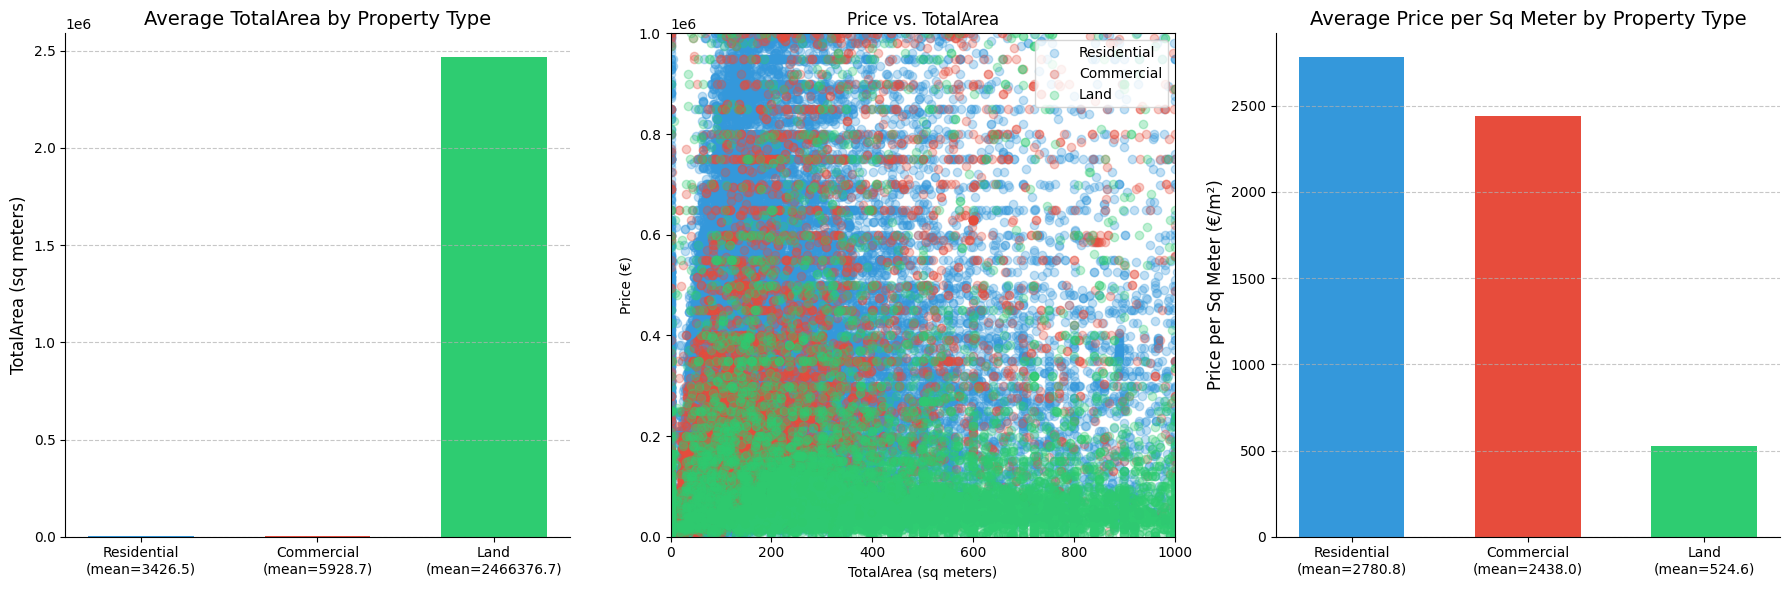

In [921]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

segments = {
    'Residential': ['Apartment', 'House', 'Duplex', 'Studio', 'Mansion', 'Manor', 'Other - Residential'],
    'Commercial': ['Warehouse', 'Other - Commercial', 'Industrial', 'Store', 'Office', 'Building'],
    'Land': ['Land', 'Farm']
}

colors = {'Residential': '#3498db', 'Commercial': '#e74c3c', 'Land': '#2ecc71'}

segment_means = []
segment_labels = []
segment_colors = []

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        mean_area = segment_data['TotalArea'].mean()
        segment_means.append(mean_area)
        segment_labels.append(f"{segment}\n(mean={mean_area:.1f})")
        segment_colors.append(colors[segment])

axes[0].bar(segment_labels, segment_means, color=segment_colors, width=0.6)
axes[0].set_title('Average TotalArea by Property Type', fontsize=14)
axes[0].set_ylabel('TotalArea (sq meters)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].spines[['top', 'right']].set_visible(False)

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        axes[1].scatter(segment_data['TotalArea'], segment_data['Price'], 
                       alpha=0.3, label=segment, c=colors[segment])
        
axes[1].set_title('Price vs. TotalArea')
axes[1].set_xlabel('TotalArea (sq meters)')
axes[1].set_ylabel('Price (€)')
axes[1].legend()
axes[1].set_xlim(0, 1000)
axes[1].set_ylim(0, 1000000)

price_means = []
price_labels = []
price_colors = []

for segment, types in segments.items():
    segment_data = dataset_clean[dataset_clean['Type'].isin(types)]
    if len(segment_data) > 0:
        mean_price = segment_data['PricePerSqM'].mean()
        price_means.append(mean_price)
        price_labels.append(f"{segment}\n(mean={mean_price:.1f})")
        price_colors.append(colors[segment])

axes[2].bar(price_labels, price_means, color=price_colors, width=0.6)
axes[2].set_title('Average Price per Sq Meter by Property Type', fontsize=14)
axes[2].set_ylabel('Price per Sq Meter (€/m²)', fontsize=12)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

#### Considerations

We can clearly see that the property types have a different `PricePerSqM` which inevitably impacts their value. 
Land cannot be compared to Residential and Commercial type of properties.
It's common sense to distinguish them and study the separately. 

In [922]:
def get_segment(property_type):
    if property_type in ["Apartment", "House", "Duplex", "Studio", "Mansion", "Manor", "Other - Residential"]:
        return "Residential"
    elif property_type in ["Warehouse", "Other - Commercial", "Industrial", "Store", "Office", "Building"]:
        return "Commercial"
    elif property_type in ["Land", "Farm"]:
        return "Land"
    else: 
        return "Other"

dataset_clean["PropertySegment"] = dataset_clean["Type"].apply(get_segment)

Now we can split data by segment: Residential, Commercial, Land and Other.
And we're going to use only __Residential, Commercial and Land__

In this case, we'll not be consider the "Other" segment, which contains: 
1. __Transfer of lease__ for a total of 1589 properties
2. __Storage__ for a total of 166 properties
3. __Hotel__ for a total of 149 properties
4. __Investment__ for a total of 222 properties
5. __Estate__ for a total of 60 properties
6. __NaN__, which represents 15 properties that are not categorised

Now we can split the data and have three different ones with different types of properties identified by `PropertySegment`

In [923]:
residential_dataset = dataset_clean[dataset_clean["PropertySegment"] == "Residential"].copy()
commercial_dataset =  dataset_clean[dataset_clean["PropertySegment"] == "Commercial"].copy()
land_dataset =  dataset_clean[dataset_clean["PropertySegment"] == "Land" ].copy()

#### Studying the fundamental differences in these datasets: residental_dataset, commercial_dataset and land_dataset

In [924]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,81.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,81.00,NaN,NaN,2.00,2753.09,Residential
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,108.00,1.00,True,Ground Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,108.00,NaN,NaN,2.00,2111.11,Residential
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,0.00,2192.98,Residential
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,114.00,1.00,True,2nd Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,114.00,NaN,NaN,2.00,2192.98,Residential
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,NaN,115.00,1.00,True,1st Floor,NaN,NaN,NaN,NaN,True,NaN,2.00,NaN,NaN,NaN,115.00,NaN,NaN,2.00,2173.91,Residential


In [925]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79573 entries, 1 to 135534
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  79348 non-null  float64
 1   District               79573 non-null  object 
 2   City                   79573 non-null  object 
 3   Town                   79573 non-null  object 
 4   Type                   79573 non-null  object 
 5   EnergyCertificate      79573 non-null  object 
 6   GrossArea              19681 non-null  float64
 7   TotalArea              79563 non-null  float64
 8   Parking                79480 non-null  float64
 9   HasParking             40216 non-null  object 
 10  Floor                  23314 non-null  object 
 11  ConstructionYear       68184 non-null  float64
 12  EnergyEfficiencyLevel  39348 non-null  object 
 13  PublishDate            19608 non-null  object 
 14  Garage                 39348 non-null  object 
 15  Elevat

In [926]:
missing_values_percentage_residential = (residential_dataset.isnull().sum() / len(residential_dataset.isnull())) * 100

missing_data_residential = pd.DataFrame(
    {
        "total missing values": residential_dataset.isnull().sum(), 
        "in %": missing_values_percentage_residential
    }
).sort_values("in %", ascending = False)

print(missing_data_residential)

                       total missing values  in %
ConservationStatus                    64895 81.55
LotSize                               61710 77.55
BuiltArea                             60902 76.54
PublishDate                           59965 75.36
GrossArea                             59892 75.27
Floor                                 56259 70.70
NumberOfWC                            45994 57.80
NumberOfBedrooms                      40382 50.75
EnergyEfficiencyLevel                 40225 50.55
Garage                                40225 50.55
ElectricCarsCharging                  40225 50.55
HasParking                            39357 49.46
TotalRooms                            20090 25.25
ConstructionYear                      11389 14.31
PricePerSqM                             812  1.02
NumberOfBathrooms                       460  0.58
LivingArea                              289  0.36
Price                                   225  0.28
Parking                                  93  0.12


In [927]:
commercial_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
6,2950000.00,Faro,Albufeira,Albufeira e Olhos de Água,Building,NC,465.00,265.00,0.00,False,NaN,1998.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,406.00,NaN,NaN,0.00,11132.08,Commercial
25,320000.00,Faro,Albufeira,Albufeira e Olhos de Água,Store,C,159.00,69.00,0.00,False,NaN,1987.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,69.00,NaN,NaN,0.00,4637.68,Commercial
51,469000.00,Faro,Loulé,São Clemente,Building,E,NaN,203.00,2.00,True,NaN,1978.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,258.00,NaN,NaN,0.00,2310.34,Commercial
57,205000.00,Faro,Portimão,Portimão,Store,C,NaN,122.00,0.00,False,Ground Floor,2005.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1680.33,Commercial
59,150000.00,Faro,Faro,Faro (Sé e São Pedro),Store,B,228.00,100.00,0.00,False,Ground Floor,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,228.00,NaN,NaN,1.00,1500.00,Commercial


In [928]:
commercial_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10666 entries, 6 to 135530
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  10647 non-null  float64
 1   District               10666 non-null  object 
 2   City                   10666 non-null  object 
 3   Town                   10666 non-null  object 
 4   Type                   10666 non-null  object 
 5   EnergyCertificate      10666 non-null  object 
 6   GrossArea              1987 non-null   float64
 7   TotalArea              10666 non-null  float64
 8   Parking                10661 non-null  float64
 9   HasParking             5473 non-null   object 
 10  Floor                  2125 non-null   object 
 11  ConstructionYear       7161 non-null   float64
 12  EnergyEfficiencyLevel  5193 non-null   object 
 13  PublishDate            2126 non-null   object 
 14  Garage                 5193 non-null   object 
 15  Elevat

In [929]:
missing_values_percentage_commercial = (commercial_dataset.isnull().sum() / len(commercial_dataset.isnull())) * 100

missing_data_commercial = pd.DataFrame(
    {
        "total missing values": residental_dataset.isnull().sum(), 
        "in %": missing_values_percentage_commercial
    }
).sort_values("in %", ascending = False)

print(missing_data_commercial)

                       total missing values  in %
NumberOfBedrooms                      40382 89.52
ConservationStatus                    64895 84.42
BuiltArea                             60902 82.05
GrossArea                             59892 81.37
Floor                                 56259 80.08
PublishDate                           59965 80.07
LotSize                               61710 79.72
TotalRooms                            20090 72.38
NumberOfWC                            45994 57.62
EnergyEfficiencyLevel                 40225 51.31
Garage                                40225 51.31
ElectricCarsCharging                  40225 51.31
HasParking                            39357 48.69
LivingArea                              289 38.29
ConstructionYear                      11389 32.86
NumberOfBathrooms                       460  8.83
PricePerSqM                             812  1.00
Price                                   225  0.18
Parking                                  93  0.05


In [930]:
land_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,GrossArea,TotalArea,Parking,HasParking,Floor,ConstructionYear,EnergyEfficiencyLevel,PublishDate,Garage,Elevator,ElectricCarsCharging,TotalRooms,NumberOfBedrooms,NumberOfWC,ConservationStatus,LivingArea,LotSize,BuiltArea,NumberOfBathrooms,PricePerSqM,PropertySegment
0,780000.00,Vila Real,Valpaços,Carrazedo de Montenegro e Curros,Farm,NC,200.00,552450.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,120.00,NaN,NaN,0.00,1.41,Land
7,165000.00,Faro,Castro Marim,Altura,Land,NC,NaN,960.00,3.00,True,NaN,2023.00,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,171.88,Land
13,75000.00,Faro,Olhão,Moncarapacho e Fuseta,Land,NC,NaN,760.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,760.00,NaN,NaN,0.00,98.68,Land
34,18500000.00,Faro,Faro,Faro (Sé e São Pedro),Land,D,NaN,45400.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,407.49,Land
40,320000.00,Leiria,Peniche,Peniche,Land,NC,0.00,3320.00,0.00,False,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1.00,96.39,Land


In [931]:
land_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33298 entries, 0 to 135535
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  33269 non-null  float64
 1   District               33298 non-null  object 
 2   City                   33298 non-null  object 
 3   Town                   33296 non-null  object 
 4   Type                   33298 non-null  object 
 5   EnergyCertificate      33298 non-null  object 
 6   GrossArea              3860 non-null   float64
 7   TotalArea              25527 non-null  float64
 8   Parking                33267 non-null  float64
 9   HasParking             16667 non-null  object 
 10  Floor                  80 non-null     object 
 11  ConstructionYear       6465 non-null   float64
 12  EnergyEfficiencyLevel  16623 non-null  object 
 13  PublishDate            5439 non-null   object 
 14  Garage                 16623 non-null  object 
 15  Elevat

In [932]:
missing_values_percentage_land = (land_dataset.isnull().sum() / len(land_dataset.isnull())) * 100

missing_data_land = pd.DataFrame(
    {
        "total missing values": land_dataset.isnull().sum(), 
        "in %": missing_values_percentage_land
    }
).sort_values("in %", ascending = False)

print(missing_data_land)

                       total missing values  in %
Floor                                 33218 99.76
ConservationStatus                    31997 96.09
NumberOfBedrooms                      29996 90.08
BuiltArea                             29515 88.64
GrossArea                             29438 88.41
PublishDate                           27859 83.67
TotalRooms                            27503 82.60
ConstructionYear                      26833 80.58
LivingArea                            22497 67.56
NumberOfWC                            19408 58.29
LotSize                               16830 50.54
EnergyEfficiencyLevel                 16675 50.08
Garage                                16675 50.08
ElectricCarsCharging                  16675 50.08
HasParking                            16631 49.95
PricePerSqM                            8004 24.04
TotalArea                              7771 23.34
NumberOfBathrooms                      4662 14.00
Parking                                  31  0.09


The assumption is that these are fundamentally different datasets representing different buildings. 
It sounds logical, but let's see if we can prove it with statistical data. 

Here we can see plot the difference in "Price" difference between the Property Types. 

__Why this is critical?__
Because these are 

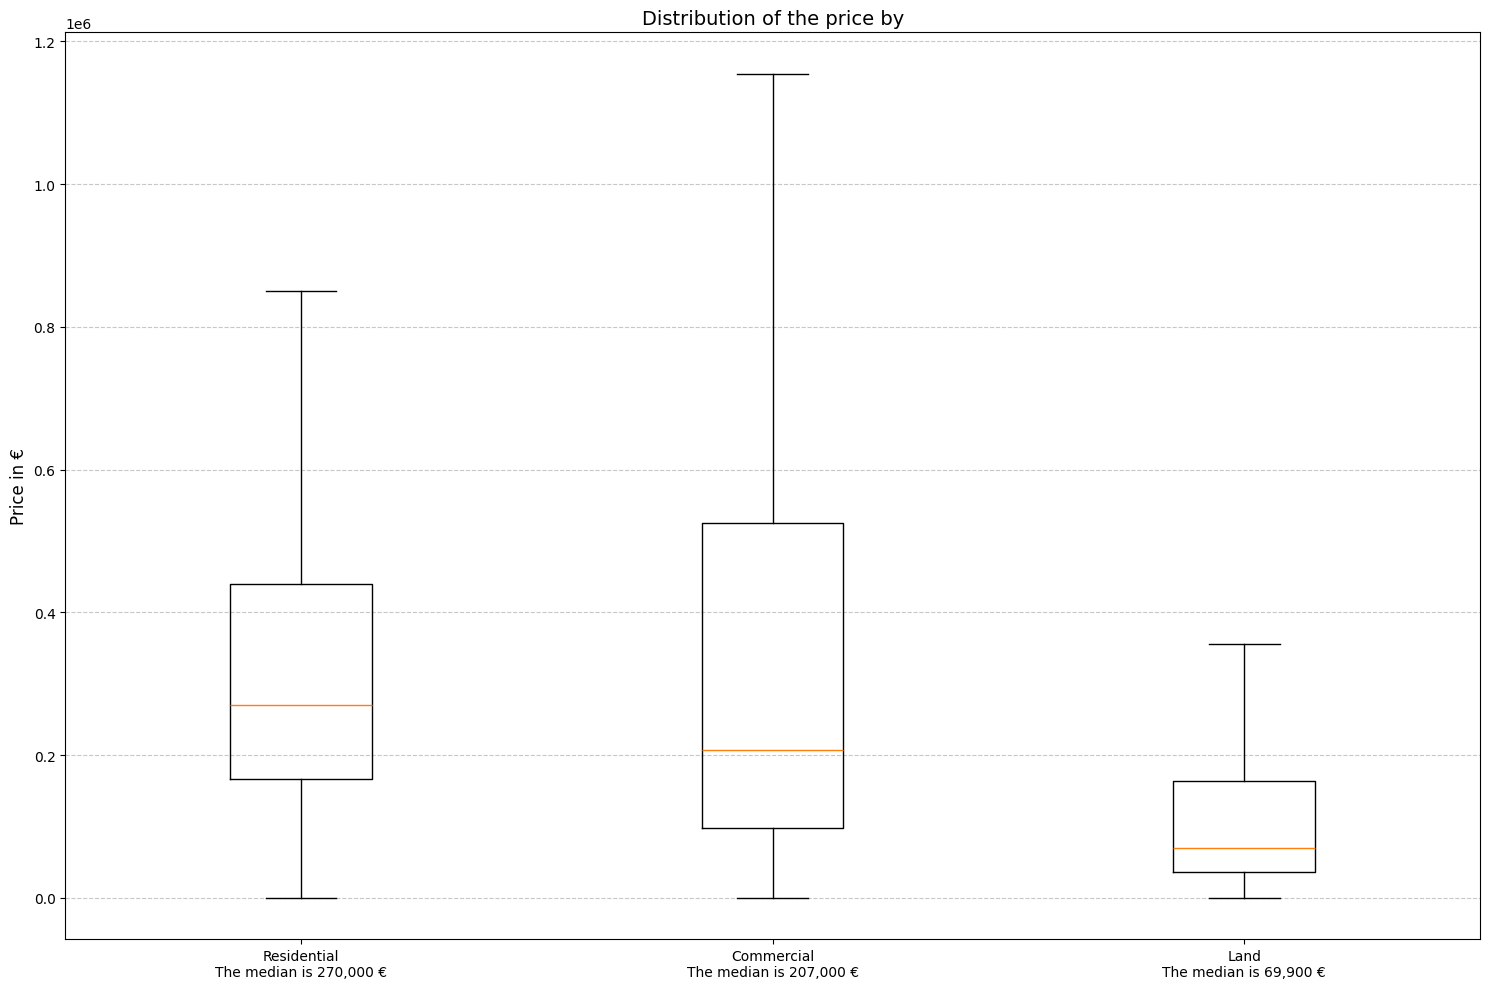

In [933]:
plt.figure(figsize=(15, 10))

data_to_plot = []
labels = []

for name, df in [('Residential', residential_dataset), ('Commercial', commercial_dataset), ('Land', land_dataset)]:
    if 'Price' in df.columns and not df['Price'].empty:
        data_to_plot.append(df['Price'].dropna())
        labels.append(f"{name}\nThe median is {df['Price'].median():,.0f} €")
plt.boxplot(data_to_plot, labels=labels, showfliers=False)
plt.title('Distribution of the price by', fontsize=14)
plt.ylabel('Price in €', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

We can clearly see that the distribution of the Residential, Commercial and Land Prices are different. 
The median values seems to be different and the IQR ranges as well. 

We can prove it with the ANOVA test. 

In [934]:
def gather_anova_groups(segment_datasets, variable):
    groups = {}
    for segment_name, df in segment_datasets.items():
        groups[segment_name] = df[variable].dropna()
    return groups

segment_datasets = {
    'Residential': residential_dataset,
    'Commercial': commercial_dataset,
    'Land': land_dataset
}

price_groups = gather_anova_groups(segment_datasets, 'Price')
price_f_stat, price_p_value = f_oneway(*price_groups.values())

print(f"F-statistic: {price_f_stat:.4f}")
print(f"p-value: {price_p_value:.10f}")
print(f"Significant difference: {price_p_value < 0.05}")

F-statistic: 25.7954
p-value: 0.0000000000
Significant difference: True


#### Decision on studying residential properties only and build prediction models for them

Hereby, I decide to proceed studying only the residential property as: 
1. We have proved that the Property types have substantial difference in the % of missing values, which gives as a critical indication in the possibilities we have in studying such datasets.
3. And that they have different Features that define them. Just look at the highes % of missing values. 
4. Also, it makes logical sense differenciating them and studying them separately.
5. Choosing to study __only residenctial_dataset__ is due to personal interest.

## Studying **residential_dataset**

Since we're studying the __residential_dataset__ we can eliminate some features that might be less relevant and have high % of missing values, like: `BuiltArea`, `PublishDate`and `GrossArea`.

Also, the absence of the `LotSize`means that either there's a lot or not. 

In [935]:
residential_dataset["HasLot"] = residential_dataset["LotSize"].notna().astype(int)
residential_dataset["HasElectricCarsCharging"] = residential_dataset["ElectricCarsCharging"].notna().astype(int)
residential_dataset["HasGarage"] = residential_dataset["Garage"].notna().astype(int)
residential_dataset["HasElevator"] = residential_dataset["Elevator"].notna().astype(int)

columns_to_drop = ["BuiltArea", "PublishDate", "GrossArea", "EnergyEfficiencyLevel", "ConservationStatus", 
                   "Garage", "ElectricCarsCharging", "LotSize", "Elevator"]

residential_dataset = residential_dataset.drop(columns=columns_to_drop)

In [936]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,Parking,HasParking,Floor,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasGarage,HasElevator
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,1.00,True,Ground Floor,NaN,2.00,NaN,NaN,81.00,2.00,2753.09,Residential,0,0,0,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,1.00,True,Ground Floor,NaN,2.00,NaN,NaN,108.00,2.00,2111.11,Residential,0,0,0,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,1.00,True,1st Floor,NaN,2.00,NaN,NaN,114.00,0.00,2192.98,Residential,0,0,0,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,1.00,True,2nd Floor,NaN,2.00,NaN,NaN,114.00,2.00,2192.98,Residential,0,0,0,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,1.00,True,1st Floor,NaN,2.00,NaN,NaN,115.00,2.00,2173.91,Residential,0,0,0,1


In [937]:
residential_dataset['HasCarPlace'] = ((residential_dataset['Parking'] > 0) | 
                                     (residential_dataset['HasGarage'] == 1) | 
                                     (residential_dataset['HasParking'] == True)).astype(int)

print(residential_dataset['HasCarPlace'].value_counts())

residential_dataset = residential_dataset.drop(columns=['Parking', 'HasGarage', 'HasParking'])

HasCarPlace
1    64828
0    14745
Name: count, dtype: int64


Transforming the information on the possibility to park the car in a parking place with `HasCarPlace`.

In [938]:
residential_dataset.shape

(79573, 20)

In [939]:
floor_counts = residential_dataset["Floor"].value_counts(dropna=False)
print(floor_counts)

Floor
NaN                 56259
1st Floor            5355
2nd Floor            4566
Ground Floor         4563
3rd Floor            3535
4th Floor            1763
5th Floor            1066
6th Floor             610
Basement Level        399
7th Floor             392
Above 10th Floor      302
8th Floor             291
9th Floor             157
Duplex                149
Top Floor              87
Basement               42
Triplex                23
Attic                   9
Mezzanine               3
Service Floor           2
Name: count, dtype: int64


In [940]:
no_floor_info = (residential_dataset['Floor'].isna().sum() / len(residential_dataset)) * 100
print(f"Percentage of residential buildings with no info {no_floor_info}")

Percentage of residential buildings with no info 70.70111721312506


In [941]:
def floor_categorisation(floor_value): 
    floor_string = str(floor_value).lower()

    if 'ground' in floor_string or 'basement' in floor_string or 'service' in floor_string:
        return 'Ground Floor'
    elif '1st' in floor_string or 'mezzanine' in floor_string:
        return 'Low - 1st'
    elif any(floor in floor_string for floor in ['2nd', '3rd', '4th', '5h']):
        return 'Mid 2nd-5th'
    elif any(floor in floor_string for floor in ['6th', '7th', '8th', '9th']) or 'top' in floor_string:
        return 'High 6th-9th'
    elif 'above 10th' in floor_string:
        return 'Very High 10+'
    elif 'duplex' in floor_string or 'triplex' in floor_string:
        return 'Multi-Level'
    elif 'attic' in floor_string:
        return 'Attic'
    else:
        return 'Other'

residential_dataset['FloorSegment'] = residential_dataset['Floor'].apply(floor_categorisation)
residential_dataset['HasFloorInfo'] = residential_dataset['Floor'].notna().astype(int)
residential_dataset = residential_dataset.drop(columns=['Floor'])

In [942]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,2.00,NaN,NaN,81.00,2.00,2753.09,Residential,0,0,1,1,Ground Floor,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,2.00,NaN,NaN,108.00,2.00,2111.11,Residential,0,0,1,1,Ground Floor,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,NaN,114.00,0.00,2192.98,Residential,0,0,1,1,Low - 1st,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,NaN,114.00,2.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,2.00,NaN,NaN,115.00,2.00,2173.91,Residential,0,0,1,1,Low - 1st,1


In [943]:
residential_dataset['TotalRestrooms'] = residential_dataset['NumberOfBathrooms'].fillna(0) + residential_dataset['NumberOfWC'].fillna(0)

both_missing_mask = residential_dataset['NumberOfBathrooms'].isna() & residential_dataset['NumberOfWC'].isna()
residential_dataset.loc[both_missing_mask, 'TotalRestrooms'] = np.nan

print("TotalRestrooms statistics:")
print(residential_dataset['TotalRestrooms'].describe())

missing_pct = residential_dataset['TotalRestrooms'].isna().mean() * 100
print(f"TotalRestrooms missing: {missing_pct:.2f}%")

TotalRestrooms statistics:
count   79113.00
mean        2.29
std         1.85
min       -28.00
25%         1.00
50%         2.00
75%         3.00
max       132.00
Name: TotalRestrooms, dtype: float64
TotalRestrooms missing: 0.58%


In [944]:
negative_restrooms = residential_dataset[residential_dataset['TotalRestrooms'] < 0]
negative_restrooms

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,NumberOfWC,LivingArea,NumberOfBathrooms,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms
11036,180000.00,Leiria,Pombal,Santiago e São Simão de Litém e Albergaria dos...,House,B-,1122.00,2011.00,2.00,NaN,NaN,90.00,-1.00,160.43,Residential,0,0,1,0,Other,0,-1.00
38614,1250000.00,Lisboa,Lisboa,Avenidas Novas,Apartment,NC,133.00,NaN,2.00,NaN,NaN,127.00,-13.00,9398.50,Residential,0,0,1,1,Mid 2nd-5th,1,-13.00
94967,1250000.00,Lisboa,Lisboa,Avenidas Novas,Apartment,NC,133.00,NaN,3.00,2.00,-15.00,127.00,-13.00,9398.50,Residential,0,1,1,1,Other,0,-28.00


We can consider the negative values as a type for the bathrooms and/or NumberOfWC

In [945]:
residential_dataset = residential_dataset[residential_dataset['TotalRestrooms'] >= 0]
residential_dataset = residential_dataset.drop(columns=['NumberOfBathrooms', 'NumberOfWC'])
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,TotalRooms,NumberOfBedrooms,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,2.00,NaN,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,2.00,NaN,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,2.00,NaN,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,2.00,NaN,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00


In [946]:
def calculate_total_living_spaces(row):
    total_rooms = row['TotalRooms']
    bedrooms = row['NumberOfBedrooms']
    
    # Handle missing values
    total_rooms = 0 if pd.isna(total_rooms) else max(0, total_rooms)  # Ensure non-negative
    bedrooms = 0 if pd.isna(bedrooms) else max(0, bedrooms)  # Ensure non-negative
    
    # If both original values were NaN, return NaN
    if pd.isna(row['TotalRooms']) and pd.isna(row['NumberOfBedrooms']):
        return np.nan
        
    # If TotalRooms is available but NumberOfBedrooms isn't, return TotalRooms
    if not pd.isna(row['TotalRooms']) and pd.isna(row['NumberOfBedrooms']):
        return total_rooms
    
    # If NumberOfBedrooms is available but TotalRooms isn't, return NumberOfBedrooms
    if pd.isna(row['TotalRooms']) and not pd.isna(row['NumberOfBedrooms']):
        return bedrooms
    
    # If both are available, check if TotalRooms >= NumberOfBedrooms (which should be true)
    if total_rooms >= bedrooms:
        return total_rooms  # TotalRooms already includes bedrooms
    else:
        return bedrooms  # If TotalRooms < Bedrooms, use Bedrooms as minimum
    
residential_dataset['TotalLivingSpaces'] = residential_dataset.apply(calculate_total_living_spaces, axis=1)
residential_dataset = residential_dataset.drop(columns=['TotalRooms', 'NumberOfBedrooms'])

In [947]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,ConstructionYear,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms,TotalLivingSpaces
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,NaN,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00,2.00
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,NaN,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00,2.00
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00,2.00
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,NaN,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00,2.00
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,NaN,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00,2.00


In [948]:
construction_year = residential_dataset["ConstructionYear"].value_counts(dropna=False)
print(construction_year)

ConstructionYear
NaN        11298
2023.00     4697
2024.00     4042
1937.00     3935
1951.00     2785
           ...  
1919.00        3
1903.00        2
1906.00        2
1909.00        2
1907.00        1
Name: count, Length: 122, dtype: int64


In [949]:
def categorize_construction_year(year):
    if pd.isna(year):
        return "Unknown"
    
    if year < 1950:
        return "Vintage (pre-1950)"
    elif year < 1990:
        return "Old (1950-1989)"
    elif year < 2010:
        return "Mid-age (1990-2009)"
    elif year < 2020:
        return "Recent (2010-2019)"
    else:
        return "Brand New (2020+)"

residential_dataset['BuildingAge'] = residential_dataset['ConstructionYear'].apply(categorize_construction_year)
residential_dataset['BuildingAge'].describe()

count               79110
unique                  6
top       Old (1950-1989)
freq                23608
Name: BuildingAge, dtype: object

In [950]:
print(residential_dataset['ConstructionYear'].isna().sum())

11298


In [951]:
year_data = residential_dataset[residential_dataset['ConstructionYear'].notna()].copy()

categorical_predictors = ['District', 'Type', 'EnergyCertificate', 'FloorSegment']

print("ANOVA test for categorical variables:")
for categorical_variable in categorical_predictors:
    if categorical_variable in year_data.columns:
        
        groups = year_data.groupby(cat_var)['ConstructionYear'].apply(list)
        
        if min(groups.apply(len)) < 5:
            print(f"{cat_var}: Insufficient data in some groups")
            continue
            
        f_value, p_value = stats.f_oneway(*groups)
        print(f"{categorical_variable}: F={f_value:.2f}, p={p_value:.6f}")

ANOVA test for categorical variables:
District: F=102.49, p=0.000000
Type: F=102.49, p=0.000000
EnergyCertificate: F=102.49, p=0.000000
FloorSegment: F=102.49, p=0.000000


In [952]:
def impute_construction_year(row):
    if pd.notna(row['ConstructionYear']):
        return row['ConstructionYear']
    
    cert_year_medians = residential_dataset.groupby('EnergyCertificate')['ConstructionYear'].median()
    
    cert = row['EnergyCertificate']
    if cert in cert_year_medians and pd.notna(cert_year_medians[cert]):
        return cert_year_medians[cert]
    
    return residential_dataset['ConstructionYear'].median()

residential_dataset['ConstructionYear_Imputed'] = residential_dataset.apply(impute_construction_year, axis=1)

residential_dataset['YearImputed'] = residential_dataset['ConstructionYear'].isna().astype(int)

residential_dataset['BuildingAge'] = residential_dataset['ConstructionYear_Imputed'].apply(categorize_construction_year)

In [953]:
residential_dataset = residential_dataset.drop(columns = ['ConstructionYear'])

print(residential_dataset['BuildingAge'].value_counts())

BuildingAge
Old (1950-1989)        29173
Mid-age (1990-2009)    22055
Brand New (2020+)      18033
Vintage (pre-1950)      5772
Recent (2010-2019)      4077
Name: count, dtype: int64


In [954]:
residential_dataset.head()

,Price,District,City,Town,Type,EnergyCertificate,TotalArea,LivingArea,PricePerSqM,PropertySegment,HasLot,HasElectricCarsCharging,HasElevator,HasCarPlace,FloorSegment,HasFloorInfo,TotalRestrooms,TotalLivingSpaces,BuildingAge,ConstructionYear_Imputed,YearImputed
1,223000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,81.00,81.00,2753.09,Residential,0,0,1,1,Ground Floor,1,2.00,2.00,Brand New (2020+),2023.00,1
2,228000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,108.00,108.00,2111.11,Residential,0,0,1,1,Ground Floor,1,2.00,2.00,Brand New (2020+),2023.00,1
3,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,114.00,2192.98,Residential,0,0,1,1,Low - 1st,1,0.00,2.00,Brand New (2020+),2023.00,1
4,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,114.00,114.00,2192.98,Residential,0,0,1,1,Mid 2nd-5th,1,2.00,2.00,Brand New (2020+),2023.00,1
5,250000.00,Faro,São Brás de Alportel,São Brás de Alportel,Apartment,A+,115.00,115.00,2173.91,Residential,0,0,1,1,Low - 1st,1,2.00,2.00,Brand New (2020+),2023.00,1


In [959]:
residential_dataset.shape

(79110, 21)

In [958]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79110 entries, 1 to 135534
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     78885 non-null  float64
 1   District                  79110 non-null  object 
 2   City                      79110 non-null  object 
 3   Town                      79110 non-null  object 
 4   Type                      79110 non-null  object 
 5   EnergyCertificate         79110 non-null  object 
 6   TotalArea                 79109 non-null  float64
 7   LivingArea                78858 non-null  float64
 8   PricePerSqM               78308 non-null  float64
 9   PropertySegment           79110 non-null  object 
 10  HasLot                    79110 non-null  int64  
 11  HasElectricCarsCharging   79110 non-null  int64  
 12  HasElevator               79110 non-null  int64  
 13  HasCarPlace               79110 non-null  int64  
 14  FloorSegme

In [961]:
residential_dataset = residential_dataset.dropna(subset = ["Price"])

residential_dataset["TotalArea"].fillna(residential_dataset["TotalArea"].median(), inplace = True)
residential_dataset["LivingArea"].fillna(residential_dataset["LivingArea"].median(), inplace = True)
residential_dataset["TotalLivingSpaces"].fillna(residential_dataset["TotalLivingSpaces"].median(), inplace=True)

missing_values_in_ppsm = residential_dataset["PricePerSqM"].isna()
residential_dataset.loc[missing_values_in_ppsm, "PricePerSqM"] = residential_dataset.loc[missing_values_in_ppsm, "Price"] / residential_dataset.loc[missing_values_in_ppsm, "TotalArea"] 

In [962]:
residential_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78885 entries, 1 to 135534
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     78885 non-null  float64
 1   District                  78885 non-null  object 
 2   City                      78885 non-null  object 
 3   Town                      78885 non-null  object 
 4   Type                      78885 non-null  object 
 5   EnergyCertificate         78885 non-null  object 
 6   TotalArea                 78885 non-null  float64
 7   LivingArea                78885 non-null  float64
 8   PricePerSqM               78885 non-null  float64
 9   PropertySegment           78885 non-null  object 
 10  HasLot                    78885 non-null  int64  
 11  HasElectricCarsCharging   78885 non-null  int64  
 12  HasElevator               78885 non-null  int64  
 13  HasCarPlace               78885 non-null  int64  
 14  FloorSegme

In [978]:
x_numeric_residential = ['TotalArea', 'LivingArea', 'PricePerSqM', 'TotalRestrooms', 'TotalLivingSpaces', 
             'ConstructionYear_Imputed']

x_categorical_residential = ['District', 'City', 'Town', 'Type', 'EnergyCertificate', 'PropertySegment',
                 'FloorSegment', 'BuildingAge']

x_binary_residential = ['HasLot', 'HasElectricCarsCharging', 'HasElevator', 'HasCarPlace', 'HasFloorInfo',
            'YearImputed']

In [979]:
residential_dataset[x_numeric_residential].describe()

,TotalArea,LivingArea,PricePerSqM,TotalRestrooms,TotalLivingSpaces,ConstructionYear_Imputed
count,78885.00,78885.00,78885.00,78885.00,78885.00,78885.00
mean,3449.09,222.21,inf,2.28,3.18,1991.97
std,335442.57,3892.10,NaN,1.84,9.96,25.90
min,-271.00,0.00,-6457.56,0.00,0.00,1900.00
25%,84.00,77.00,1080.40,1.00,2.00,1979.00
50%,123.00,107.00,2189.02,2.00,3.00,1994.00
75%,220.00,162.00,3581.08,3.00,4.00,2014.00
max,56215100.00,470300.00,inf,132.00,2751.00,2025.00


## EDA for Residential Properties Price Prediction

Price distribution

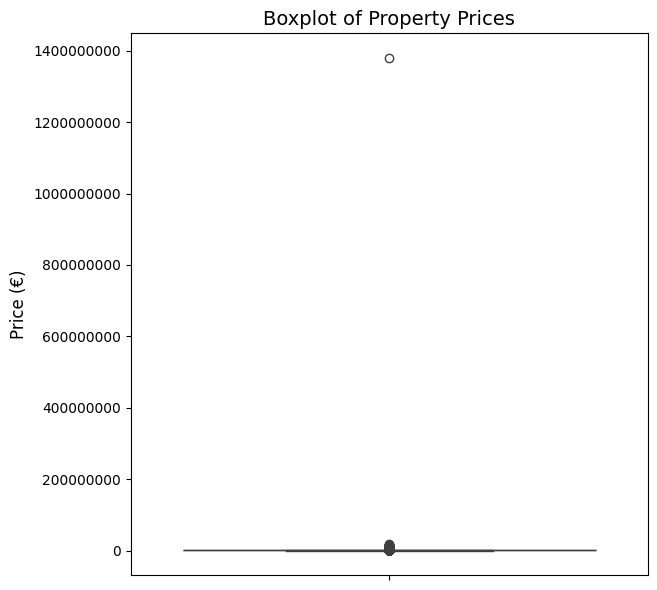

In [964]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.boxplot(y=residential_dataset['Price'])
plt.title('Boxplot of Property Prices', fontsize=14)
plt.ylabel('Price (€)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

We have a __€1.4billion__ outlier that makes the price data not-readable. 
The best thing to do here is to delete it completely. 

In [968]:
max_price = residential_dataset['Price'].max()
print(f"max_price {max_price}€")

max_price 1380000000.0€


In [970]:
price_threshold = 1000000000  
residential_dataset_cleaned = residential_dataset[residential_dataset['Price'] <= price_threshold]

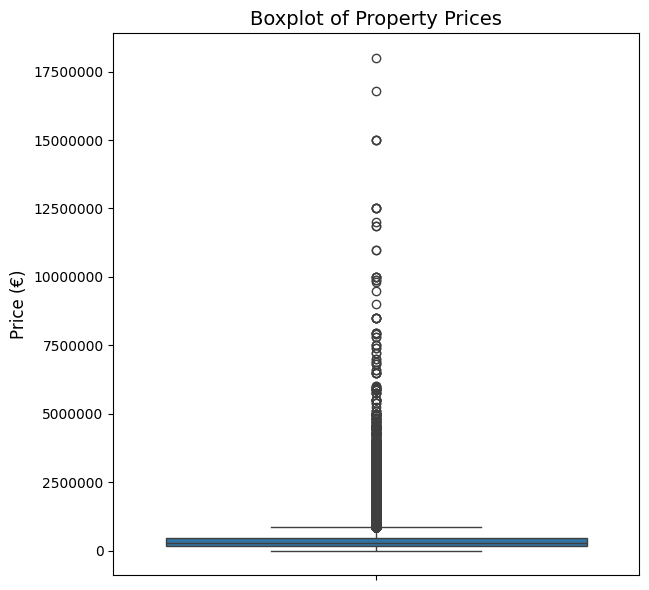

In [971]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.boxplot(y=residential_dataset_cleaned['Price'])
plt.title('Boxplot of Property Prices', fontsize=14)
plt.ylabel('Price (€)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

In [977]:
residential_dataset_cleaned[x_numeric].describe()

KeyError: "['GrossArea', 'Parking', 'ConstructionYear', 'TotalRooms', 'NumberOfBedrooms', 'NumberOfWC', 'LotSize', 'BuiltArea', 'NumberOfBathrooms'] not in index"